# Modeling Corporate Housing

## Brainstation Capstone Project


### Spencer Cox
### Summer, 2022

#### Objective

The objective of this notebook is to create a model to predict the odds of a corporation purchasing a residential single-family parcel in the metropolitan Twin Cities region. We will use a Logistic Regression model.

The datasets used for this analysis are the twincities_parcels and the twincities_tracts geopackages. 

The Parcels dataset contains every residential parcel in the Twin City region, including single family, small multi-family, and large multi-family properties. For this analysis, we will select small single family and small multi-family properties (small multi-family parcels include duplexes and triplexes). Corporate properties have been identified by examining the tax name - corproate properties are properties owned by tax names that include common identifiers for corporations (see the parcel_preprocessing notebook for the detailed process of creating the cleaned dataset).

The Tracts dataset (twincities_tracts) includes demographic, economic, housing, transit, and parcel related attributes for each census tract in the study area. Please see the Preprocessing notebook to see the overview of the dataset, the origins of datasources, features created, and the cleaning process.

Exploratory statistical analysis and overview of each dataset is completed in the Twin_Cities_EDA notebook where we examine the spatial patterns of both our target and feature attributes. Here we visualized some of the clustering behavior of various attributes in space, viewing neighborhood patterns in more depth. The overview helps situate one in the specificities of the Twin City region, and the spatial structures embedded in the region's geography. The purpose of the modeling is to understand the underlying spatial relationships that structure the patterns of corporate single family ownership.

#### Work Plan

The first objective is to prepare the dataset for modeling. Our dataset will be a spatial join of the parcels and tracts datasets, with the attributes of the tracts joined onto each parcel. Therefore each parcel will contain not only information about that particular parcel, but various information about parcels in the same census tract, contextualizing the parcel within a broader neighborhood.

Our target variable we are modeling is a binary:
    - 1: Is owned by a corporation
    - 0: Is not owned by a corporation

Our attributes will be selected to reduce multi-collinearity, and all will be transformed from categorical data to numerical data when appropriate.

We will then follow the classic ML pipeline:
 - Split into test and train sets
 - Scale the data
 - Choose and fit a model
 - Cross-Validate
 - Score
 
Given the distribution of the dataset, we will also experiment with SMOTE techniques for imbalanced data. We will also optimize our model's hyperparameters.

We will then assess the accuracy and precision of the model.

In [1]:
# Import key packages for preparing dataframe - additional packages will be added as they are relevant

import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import contextily as cx


# Set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prepare Dataset

We will import our two different dataframes, spatially join them together, and prepare them for modeling by extracting our 
feature variables.

In [2]:
# Import Parcels and Tracts dataframes
parcels = gpd.read_file('twincities_parcels.gpkg')
tracts = gpd.read_file('twincities_tracts.gpkg')

In [3]:
#spatially join the parcels together
parcels_gdf = parcels.sjoin(tracts, how='left', predicate = 'within') 

In [4]:
#Check Data Completeness
parcels_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 968441 entries, 0 to 968440
Data columns (total 55 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   COUNTY_PIN       968441 non-null  object  
 1   County           968441 non-null  object  
 2   TAX_NAME         968441 non-null  object  
 3   taxed_zip        968441 non-null  object  
 4   Use_Class        968441 non-null  object  
 5   Last_Sale_Date   968441 non-null  int64   
 6   YEAR_BUILT       968441 non-null  int64   
 7   EMV_TOTAL        968441 non-null  float64 
 8   Homestead        968441 non-null  int64   
 9   Corporate        968441 non-null  int64   
 10  TAXOWN_NOTMN     968441 non-null  int64   
 11  geometry         968441 non-null  geometry
 12  index_right      968440 non-null  float64 
 13  TR10             968440 non-null  object  
 14  CTU_PRMRY        968440 non-null  object  
 15  POPTOT_MC        968440 non-null  float64 
 16  AGE_DIV     

In [5]:
# Drop the one parcel that falls outside the geography of the tracts
parcels_gdf.dropna(axis = 0, inplace=True)

# Check nulls
parcels_gdf.isna().sum()

COUNTY_PIN         0
County             0
TAX_NAME           0
taxed_zip          0
Use_Class          0
Last_Sale_Date     0
YEAR_BUILT         0
EMV_TOTAL          0
Homestead          0
Corporate          0
TAXOWN_NOTMN       0
geometry           0
index_right        0
TR10               0
CTU_PRMRY          0
POPTOT_MC          0
AGE_DIV            0
IMM_DIV            0
RACIAL_DIV         0
PBLACKNH           0
PPOV185            0
ACP                0
PPOV500            0
ACA                0
TR_EDA             0
INCOME_DIV         0
INC_CHG            0
OE_BC              0
NE_LW              0
NE_MW              0
NE_HW              0
PHFTRANSIT         0
COMMLENGTH         0
PCOMMTRANS         0
PJOB_LT5           0
TR_EJ              0
ENV_PM25           0
PMV                0
NBR_STAB           0
POWNHOME           0
PCOSTBURD          0
RP_NETCHG          0
TR_QUALIF          0
OWNER_RATIO        0
RENT_CHG           0
EMV_CHG            0
AFF_CHG            0
TR_PARCELSALL

In [6]:
# Extract only single-family and small multifamily parcels
model_gdf = parcels_gdf.loc[(parcels_gdf['Use_Class'] == 'Single_Family') | (parcels_gdf['Use_Class'] == 'Multifamily_Small')]

In [7]:
# Assess our df
model_gdf['Use_Class'].value_counts()

Single_Family        929054
Multifamily_Small     21891
Name: Use_Class, dtype: int64

### Select Columns for the Modeling DF

With our primary single family, duplex, and triplex dataframe loaded into memory, we will now extract the relevant target and feature variables.

Our target feature is the binary = `Corporate`

Our starting features are = 
Last_Sale_Date
YEAR_BUILT
EMV_TOTAL
AGE_DIV
IMM_DIV 
RACIAL_DIV
PBLACKNH
PPOV185
ACP
PPOV500    
ACA                
TR_EDA             
INCOME_DIV         
INC_CHG            
OE_BC              
NE_LW            
NE_MW            
NE_HW              
PHFTRANSIT         
COMMLENGTH         
PCOMMTRANS         
PJOB_LT5           
TR_EJ              
ENV_PM25           
PMV                
NBR_STAB           
POWNHOME           
PCOSTBURD          
RP_NETCHG          
TR_QUALIF          
OWNER_RATIO        
RENT_CHG           
EMV_CHG            
AFF_CHG
geometry

In [8]:
model_df = model_gdf[['Last_Sale_Date', 'YEAR_BUILT', 'EMV_TOTAL', 'AGE_DIV', 'IMM_DIV', 'RACIAL_DIV', 'PBLACKNH', 'PPOV185', \
'ACP', 'PPOV500', 'ACA', 'TR_EDA', 'INCOME_DIV', 'INC_CHG', 'OE_BC', 'NE_LW', 'NE_MW', 'NE_HW', 'PHFTRANSIT',\
'COMMLENGTH', 'PCOMMTRANS', 'PJOB_LT5', 'TR_EJ', 'ENV_PM25', 'PMV', 'NBR_STAB', 'POWNHOME', 'PCOSTBURD', \
'RP_NETCHG', 'TR_QUALIF', 'OWNER_RATIO', 'RENT_CHG', 'EMV_CHG', 'AFF_CHG', 'Corporate', 'geometry']]

model_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 950945 entries, 0 to 968440
Data columns (total 36 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Last_Sale_Date  950945 non-null  int64   
 1   YEAR_BUILT      950945 non-null  int64   
 2   EMV_TOTAL       950945 non-null  float64 
 3   AGE_DIV         950945 non-null  float64 
 4   IMM_DIV         950945 non-null  float64 
 5   RACIAL_DIV      950945 non-null  float64 
 6   PBLACKNH        950945 non-null  float64 
 7   PPOV185         950945 non-null  float64 
 8   ACP             950945 non-null  float64 
 9   PPOV500         950945 non-null  float64 
 10  ACA             950945 non-null  float64 
 11  TR_EDA          950945 non-null  float64 
 12  INCOME_DIV      950945 non-null  float64 
 13  INC_CHG         950945 non-null  float64 
 14  OE_BC           950945 non-null  float64 
 15  NE_LW           950945 non-null  float64 
 16  NE_MW           950945 non-nul

### Overview of the Model DF

First, we will assess the proportion of corproate owned parcels relative to total parcels in the dataframe.

In [9]:
# Target feature as proportion to total rows
corporate_ratio = model_df['Corporate'].value_counts()

print(f'Corporate parcels are {round(corporate_ratio[1]/(corporate_ratio[0]+corporate_ratio[1])*100, 2)}% of the total amount of parcels.')

Corporate parcels are 3.2% of the total amount of parcels.


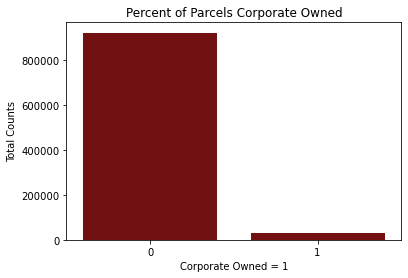

In [10]:
# visualize proportion of values to see if balanced
sns.barplot(x = corporate_ratio.index, y = corporate_ratio.values, color = 'maroon')
plt.xlabel('Corporate Owned = 1')
plt.ylabel('Total Counts')
plt.title('Percent of Parcels Corporate Owned')
plt.show()

Given the imbalance in the data, our model's ability to recognize a corporate owned parcel as such (it's accuracy) may be impacted, requiring techniques to synthetically increase the ratio to ensure proper identification. There are tradeoffs with this techinque, as it also can drastically lower our precision (incorrectly classifying a parcel as corporate owned even though it is not). We will try modeling first without rebalancing, and then a second attempt with modeling.

#### Dependent and Independent Variables

In [11]:
# separating our independent and dependent variables

#Independent Variables
X = model_df.drop(columns=['Corporate', 'geometry'])

#Target Variable
y = model_df['Corporate']

In [12]:
#Verify
print(X.shape)
print(y.shape)
print(model_df.shape)

(950945, 34)
(950945,)
(950945, 36)


In [13]:
X.head()

,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG
0,2011,1987,343900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741
1,2015,1996,382700.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741
2,1996,1996,537900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741
3,1998,1998,354000.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741
4,2021,1995,288900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741


Our target variable has all the rows and only one column and our independent variables contains all columns but the target variable. Good to go.

#### Train Test Split
We will now split our dataset into train/test splits.

In [14]:
# Bring in some initial packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score


In [15]:
# Train Test split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= y)

*Stratify is used here to ensure that the class proportions of the whole dataset is preserved as well as possible in the train and test sets*

In [16]:
# Check the class proportions again
print('Train set class proportions:')
print(y_train.value_counts(normalize=True), '\n')
print('Test set class proportions:')
print(y_test.value_counts(normalize=True))

Train set class proportions:
0    0.967994
1    0.032006
Name: Corporate, dtype: float64 

Test set class proportions:
0    0.967994
1    0.032006
Name: Corporate, dtype: float64


#### Scale our Features Sets (train and test) Independently

Prior to fitting our model, we will scale the training and test sets using the standard scaler.


In [17]:
from sklearn.preprocessing import StandardScaler

#Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the train set
scaler.fit(X_train)

#Transform and scale both X_train and X_Test sets.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Fit a Logisitic Regression Model

We will used the limited memory BFGS solver (lbfgs) which aids with computational efficiency. We will then test our model on our training score.

In [18]:
# Instatiate logistic model
logreg = LogisticRegression(solver='lbfgs')

# Fit log regression model to the training data
logreg.fit(X_train_scaled, y_train)

# Score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Test score: {logreg.score(X_test_scaled, y_test)}")

Train score: 0.9679714753620262
Test score: 0.9679645995364625


That's a very high train and test score for a logistic model, certainly making me raise my eyebrows suspiciously.

In [19]:
# Retrieve y predictions
y_pred = logreg.predict(X_test)

#Put into df and check
class_df = pd.DataFrame(y_pred, columns=['predicted_class'])
class_df['predicted_class'].value_counts()

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0    237678
1        59
Name: predicted_class, dtype: int64

In [20]:
#Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

cf_matrix

array([[230090,     38],
       [  7588,     21]], dtype=int64)

In [21]:
# Get Classification report
log_report = classification_report(y_test, y_pred)
print(log_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    230128
           1       0.36      0.00      0.01      7609

    accuracy                           0.97    237737
   macro avg       0.66      0.50      0.49    237737
weighted avg       0.95      0.97      0.95    237737



The accuracy score was so high because it identifed all parcels as non-corporate, mis-classifying the 4% that are corporate owned, but correctly identifying 96% of noncorporate parcels as non-corporate.  

The precision score for corporate of .15 means that only 15% of properties that actually are corporately owned were identified as such.

Let's try resampling the data with the SMOTE algorithm that creates synthetic 'corporate' points to assist in training our model.

#### Resample with Smote

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE().fit_resample(X_train, y_train)

In [24]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


0    690381
1     22827
Name: Corporate, dtype: int64


Resampled class distribution


0    690381
1    690381
Name: Corporate, dtype: int64

In [25]:
# scale the sampled train data and the unsampled test data

#instantiate
ss_sm = StandardScaler().fit(X_train_sm)

#fit to X_train and X_test

X_train_sm_ss = ss_sm.transform(X_train_sm)
X_test_ss = ss_sm.transform(X_test)

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [26]:
# Instatiate logistic model
logreg_sm = LogisticRegression(solver='lbfgs')

# Fit log regression model to the training data
logreg_sm.fit(X_train_sm_ss, y_train_sm)

# Score
print(f"Train score: {logreg_sm.score(X_train_sm_ss, y_train_sm)}")
print(f"Test score: {logreg_sm.score(X_test_ss, y_test)}")

Train score: 0.6602064657051686
Test score: 0.746417259408506


Not an excellent score on the training data. Again, we can interpret this from a distance. Here, where we've boosted simulations of the corporate owned parcels through the SMOTE method for our test set, we are doing only slightly better at understanding which parcels are or are not corporate owned.

Let's try to fine tune our hyper-parameters to optimize our accuracy.

#### Hyperparameter Optimization

We will us a cross validation to identify an optimal C hyperparameter for the logistic model on the SMOTE dataset.

In [27]:
from sklearn.model_selection import cross_val_score

# Use Cross Validation on a Logistic Model to select optimal C - hyperparameter
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    LR_model_sm = LogisticRegression(solver='lbfgs', C=c)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model_sm, X_train_sm_ss, y_train_sm, cv = 5))
    
    cross_validation_scores.append(cv_score)

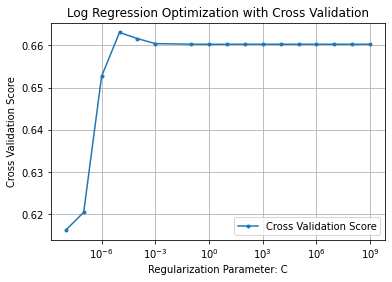

The best model has C =  1e-05


In [28]:
#Plot the CV Scores to search for elbow
plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.title('Log Regression Optimization with Cross Validation')
plt.grid()
plt.show()

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

Our initial model was run with C = 1.0, so let's run it with the new hyperparameter. Should be marginally better.

In [29]:
# Instatiate logistic model
logreg_sm_op = LogisticRegression(solver='lbfgs', C=10)

# Fit log regression model to the training data
logreg_sm_op.fit(X_train_sm_ss, y_train_sm)

# Score
print(f"Train score: {logreg_sm_op.score(X_train_sm_ss, y_train_sm)}")
print(f"Test score: {logreg_sm_op.score(X_test_ss, y_test)}")

Train score: 0.6602115353696003
Test score: 0.7463962277642942


### Model Evaluation

With our model in hand, let's evaluate it in more depth.

In [30]:
# class distribution
display(y_test.value_counts())

# predict classification
y_test_pred = logreg_sm_op.predict(X_test_ss) # using the unsampled but scaled test data

# confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.1f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.1f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.1f}%')

0    230128
1      7609
Name: Corporate, dtype: int64

,predicted 0,predicted 1
true 0,173248,56880
true 1,3411,4198


Recall score: 55.2%
Precision score: 6.9%
F1 score: 12.2%


In [31]:
# Get Classification report
log_report = classification_report(y_test, y_test_pred)
print(log_report)

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    230128
           1       0.07      0.55      0.12      7609

    accuracy                           0.75    237737
   macro avg       0.52      0.65      0.49    237737
weighted avg       0.95      0.75      0.83    237737



This isn't great! Our precision score of 7.7% holds that of parcels identified as corporate, only 7.7% actually are. Yikes! On the other hand, we are actually predicinting 50.7% of the parcels that actually are corporate (better than before, at least!).

#### Analysis
Sooo, it looks like even with attempting to address the imbalance in the data, the dataset seems poorly attuned to capturing the variance. Nonetheless, let's analyze what it found.

In [32]:
#extract features from our X_train df
features = list(X_train.columns.values)

#Create new dataframe with a coefficient column and a matching features column. 
#The coefficient array follows the same order as the training set.

logreg_coefficients = pd.DataFrame({'coefficient': logreg_sm_op.coef_[0], 'variable': features})  
logreg_coefficients.head()



,coefficient,variable
0,0.129260,Last_Sale_Date
1,-0.605433,YEAR_BUILT
2,-0.116482,EMV_TOTAL
3,-0.029763,AGE_DIV
4,-0.078618,IMM_DIV


In [33]:
#Take a glimpse at the most impactful variables
logreg_coefficients_rank = logreg_coefficients.sort_values(by = 'coefficient', ascending = False)


In [34]:
# most negative coefficients!
neg_coeff = logreg_coefficients_rank.tail(6)
pos_coeff = logreg_coefficients_rank.head(6)

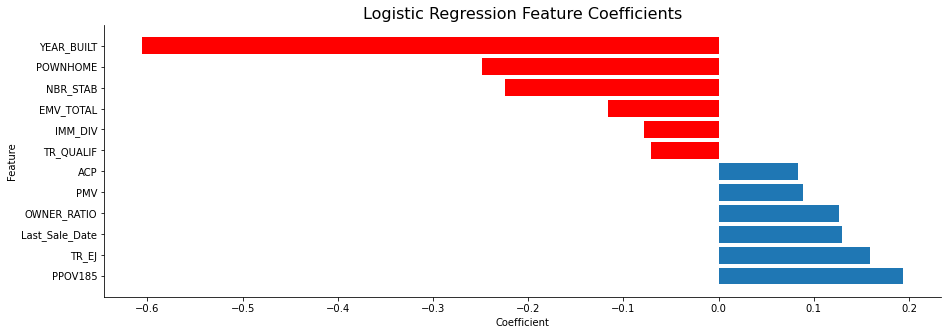

In [35]:
#Visualize
plt.figure(figsize=(15,5))
plt.barh(pos_coeff['variable'], pos_coeff['coefficient'])
plt.barh(neg_coeff['variable'], neg_coeff['coefficient'], color = 'r')
plt.title('Logistic Regression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.savefig('charts/coefficients.png')
plt.show()


### An additional visualization

I'd like to visualize how the model's predictions are organized spatially, creating a heatmap of predicted corporate housing density. This will be useful, then, to compare to the original.

I'll to this by using the model to predict based on the full X dataframe.

In [36]:
# Make a copy of X
X1 = X


In [37]:
model_df['predictions'] = logreg_sm_op.predict(X1)

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [38]:
model_df.head()

,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,Corporate,geometry,predictions
0,2011,1987,343900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,1,POINT (468988.693 5026377.395),0
1,2015,1996,382700.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469548.186 5026281.306),0
2,1996,1996,537900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469374.511 5026384.153),0
3,1998,1998,354000.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469323.226 5026492.734),0
4,2021,1995,288900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469536.277 5026429.696),0


In [39]:
# Visualization in Seaborn is made easier with x,y coordinate points (create x y points from geometry file)
model_df['x'] = model_df.geometry.x
model_df['y'] = model_df.geometry.y
model_df.head()

,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,Corporate,geometry,predictions,x,y
0,2011,1987,343900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,1,POINT (468988.693 5026377.395),0,468988.6928,5.026377e+06
1,2015,1996,382700.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469548.186 5026281.306),0,469548.1858,5.026281e+06
2,1996,1996,537900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469374.511 5026384.153),0,469374.5113,5.026384e+06
3,1998,1998,354000.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469323.226 5026492.734),0,469323.2261,5.026493e+06
4,2021,1995,288900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469536.277 5026429.696),0,469536.2772,5.026430e+06


In [40]:
#Extract Corporate Predicted and Corporate Actual
corporate_actual = model_df.loc[model_df['Corporate'] == 1]
corporate_predicted = model_df.loc[model_df['predictions']== 1]

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


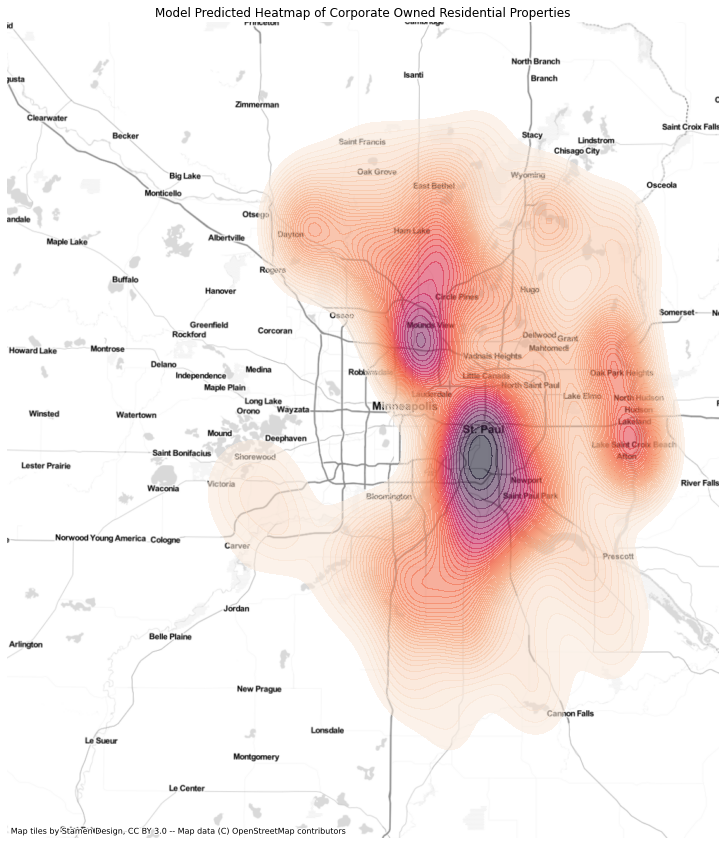

In [41]:
#Heatmap Corporate Predicted

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(15, 15))
# Generate and add KDE with a shading of 50 gradients coloured contours, 75% of transparency,
sns.kdeplot(corporate_predicted['x'], corporate_predicted['y'], n_levels=50, shade=True, alpha=0.55, cmap='rocket_r')
# Add basemap
cx.add_basemap(ax, crs=parcels.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=10)

# Remove axes
ax.set_axis_off()
ax.set_title('Model Predicted Heatmap of Corporate Owned Residential Properties')
plt.savefig('charts/heatmap_predicted.png')

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


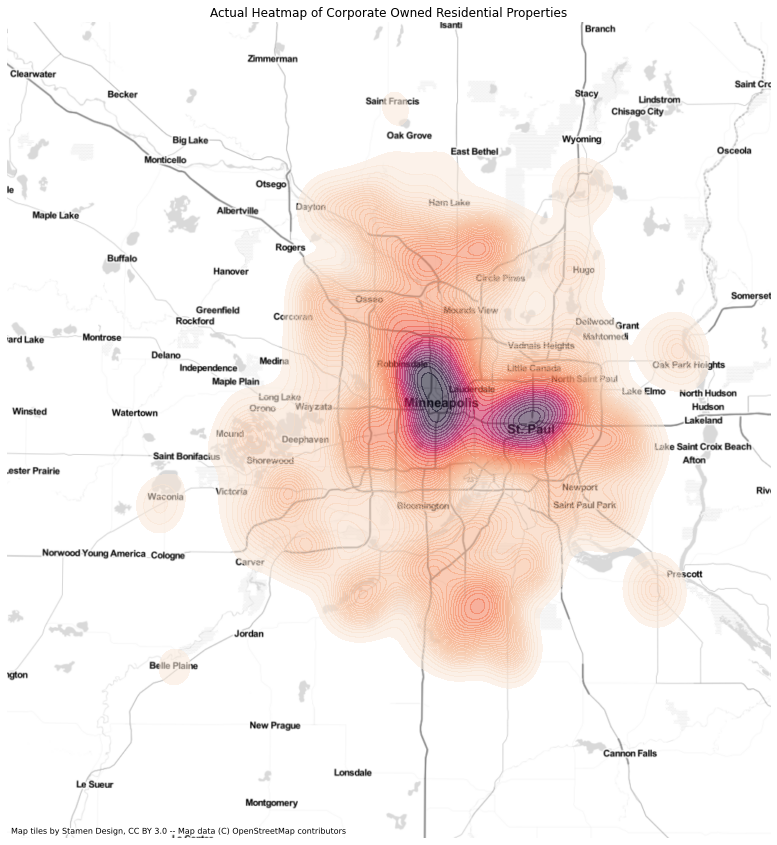

In [42]:
#Heatpmap Corporate Actual

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(15, 15))
# Generate and add KDE with a shading of 50 gradients coloured contours, 75% of transparency,
sns.kdeplot(corporate_actual['x'], corporate_actual['y'], n_levels=50, shade=True, alpha=0.55, cmap='rocket_r')
# Add basemap
cx.add_basemap(ax, crs=parcels.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=10)

# Remove axes
ax.set_axis_off()
ax.set_title('Actual Heatmap of Corporate Owned Residential Properties')
plt.savefig('charts/heatmap_actual.png')

## Analysis

With accuracy hovering around 63%, our model did an adequate job of predicting which parcels would be corproate owned. As seen in the heatmap, it overpredicts St Paul relative to Minneapolis neighborhoods, displacing the epicenter. However, on its own merits, it seems to roughly identify downtown neighborhoods and first ring working class suburbs as key spaces for corporate ownership.

At first glance, the model is perplexing. Both Areas of Concentrated Poverty and Areas of Concetrated Affluence having a strong positive effect on the odds of a parcel being categorized as corporate owned. It also seems to correctly identify that odds increase for properties in neighborhoods with higher percentage of low wage service sector employees (retail, food service, warehousing, transportation), but less so for middle wage new economy jobs (nurses, teachers, non-profit workers, etc.). Strangely, racial and immigrant diversity have a negative impact - as neighborhoods get more diverse, supposedly, it lowers the odds of being identifed as corporate in the model (something that is distincty *untrue* about the observed data, especially in the North Minneapolis and western St Paul areas in the actual dataset.

Here is my hypothesis on why there is contradictory information in the model:

The model is confused between the different waves of corporate property acquisition waves dovetailed with the city's demographics. As I detailed at the end of the EDA, the first major wave began after 2009 with the acquisition of foreclosed homes that was highly concentrated in low wage, diverse census tracts in North Minneapolis and St Paul. The shift, however, started to move towards new tracts of suburban development in deeply white neighborhoods, many of which even are in the wealthy tracts southwest of the city. Some of this new housing owned by corporate entities may be new construction to be sold to new buyers, but a new strategy of home developers is to sell stock directly to single-family for-rent corporations (such as invitation homes and blackrock's new acquisition strategies). This creates contradictory demographic/economic/racial information that can change the model's outcome.

## Two Different Models for Pre and Post-Pandemic

We are going to the hypothesis that the patterns of single-family acquisition demonstrate different patterns pre and post-pandemic.



In [43]:
# Separate by sale date
model_gdf['postp_corp'] = np.where((model_gdf['Last_Sale_Date'] >= 2020) & (model_gdf['Corporate'] == 1), 1, 0)
model_gdf['prep_corp'] = np.where((model_gdf['Last_Sale_Date'] < 2020) & (model_gdf['Corporate'] == 1), 1, 0)

In [44]:
# Sanity check
corporate_postp = model_gdf.loc[model_gdf['postp_corp'] == 1]
corporate_postp.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,Homestead,Corporate,TAXOWN_NOTMN,geometry,index_right,TR10,CTU_PRMRY,POPTOT_MC,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,TR_MULTIFAM_ALL,MFOWN_NOTMN,MED_YRBUILT,RATIO_CORPSF,RATIO_NOTMNMF,postp_corp,prep_corp
168,363423310011,Anoka,CTW GROUP INCORPORATED,55416,Single_Family,2021,1980,270600.0,0,1,0,POINT (487913.585 5026218.045),2.0,27003050109,East Bethel,5720.0,0.778142,0.035470,0.133992,0.004,0.118,0.0,0.401,0.0,0.0,0.775221,-3.425043,0.267959,0.301971,0.296567,0.133503,0.0,34.44,0.010,0.219,0.0,6.941,0.054,1.313127,0.927,0.148,111.0,0.0,0.933000,48.837209,28.765990,-58.566323,1950.0,1943.0,35.0,7.0,0.0,1989.0,0.018013,0.0,1,0
215,363423120009,Anoka,PICOTTE CUSTOM HOMES INC,55011,Single_Family,2021,0,61700.0,0,1,0,POINT (488322.599 5027024.574),2.0,27003050109,East Bethel,5720.0,0.778142,0.035470,0.133992,0.004,0.118,0.0,0.401,0.0,0.0,0.775221,-3.425043,0.267959,0.301971,0.296567,0.133503,0.0,34.44,0.010,0.219,0.0,6.941,0.054,1.313127,0.927,0.148,111.0,0.0,0.933000,48.837209,28.765990,-58.566323,1950.0,1943.0,35.0,7.0,0.0,1989.0,0.018013,0.0,1,0
499,363323240268,Anoka,WHITE PINES GENERAL STORE INC,55422,Single_Family,2020,0,43000.0,0,1,0,POINT (487873.572 5016983.030),4.0,27003050111,East Bethel,3751.0,0.773435,0.047213,0.100611,0.009,0.091,0.0,0.440,0.0,0.0,0.773256,1.390666,0.286686,0.257046,0.310496,0.145773,0.0,37.30,0.014,0.267,0.0,7.078,0.089,1.231056,0.941,0.099,28.0,0.0,0.879477,-13.536776,27.363291,-55.568749,1636.0,1631.0,24.0,5.0,0.0,1977.0,0.014715,0.0,1,0
638,363323210306,Anoka,F PALOMINO INC,55056,Single_Family,2021,1948,247200.0,0,1,0,POINT (487935.921 5017442.773),4.0,27003050111,East Bethel,3751.0,0.773435,0.047213,0.100611,0.009,0.091,0.0,0.440,0.0,0.0,0.773256,1.390666,0.286686,0.257046,0.310496,0.145773,0.0,37.30,0.014,0.267,0.0,7.078,0.089,1.231056,0.941,0.099,28.0,0.0,0.879477,-13.536776,27.363291,-55.568749,1636.0,1631.0,24.0,5.0,0.0,1977.0,0.014715,0.0,1,0
839,363322140010,Anoka,GUIDANCE HOMES INC,55025,Single_Family,2021,0,108100.0,0,1,0,POINT (498189.155 5016774.793),9.0,27003050210,Columbus,4067.0,0.799197,0.075893,0.237969,0.000,0.106,0.0,0.451,0.0,0.0,0.764938,4.540373,0.229001,0.280283,0.329797,0.160920,0.0,31.40,0.000,0.115,0.0,7.175,0.081,1.723479,0.936,0.159,85.0,0.0,0.919397,-25.565801,32.171761,-67.307692,1734.0,1730.0,55.0,4.0,0.0,1979.0,0.031792,0.0,1,0


In [45]:
# Sanity Check 2
corporate_prep = model_gdf.loc[model_gdf['prep_corp']== 1]
corporate_prep.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,Homestead,Corporate,TAXOWN_NOTMN,geometry,index_right,TR10,CTU_PRMRY,POPTOT_MC,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,TR_MULTIFAM_ALL,MFOWN_NOTMN,MED_YRBUILT,RATIO_CORPSF,RATIO_NOTMNMF,postp_corp,prep_corp
0,363425420001,Anoka,VESTA MINNESOTA PROPERTIES LLC,55443,Single_Family,2011,1987,343900.0,0,1,0,POINT (468988.693 5026377.395),0.0,27003050107,St. Francis,3034.0,0.699942,0.000000,0.076826,0.000,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.000,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.887350,25.000000,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,1
228,363423110012,Anoka,T H CONSTRUCTION OF ANOKA INC,55303,Single_Family,2006,0,61700.0,0,1,0,POINT (488485.288 5027284.611),2.0,27003050109,East Bethel,5720.0,0.778142,0.035470,0.133992,0.004,0.118,0.0,0.401,0.0,0.0,0.775221,-3.425043,0.267959,0.301971,0.296567,0.133503,0.0,34.44,0.010,0.219,0.0,6.941,0.054,1.313127,0.927,0.148,111.0,0.0,0.933000,48.837209,28.765990,-58.566323,1950.0,1943.0,35.0,7.0,0.0,1989.0,0.018013,0.0,0,1
436,363324120005,Anoka,PAKONEN PROPERTIES LLC,55304,Single_Family,2005,0,109300.0,0,1,0,POINT (478728.140 5017506.844),6.0,27003050115,Oak Grove,5847.0,0.752383,0.090758,0.238801,0.012,0.068,0.0,0.430,0.0,0.0,0.757621,5.928245,0.248906,0.280488,0.323952,0.146654,0.0,36.31,0.009,0.245,0.0,7.061,0.082,1.395197,0.995,0.183,222.0,0.0,0.929605,-29.145729,18.994046,-64.830752,2174.0,2174.0,45.0,0.0,0.0,1987.0,0.020699,0.0,0,1
512,363323240206,Anoka,EQUITY TRUST COMPANY CUSTODIAN FBO,55448,Single_Family,2018,0,19200.0,0,1,0,POINT (487697.218 5016962.569),4.0,27003050111,East Bethel,3751.0,0.773435,0.047213,0.100611,0.009,0.091,0.0,0.440,0.0,0.0,0.773256,1.390666,0.286686,0.257046,0.310496,0.145773,0.0,37.30,0.014,0.267,0.0,7.078,0.089,1.231056,0.941,0.099,28.0,0.0,0.879477,-13.536776,27.363291,-55.568749,1636.0,1631.0,24.0,5.0,0.0,1977.0,0.014715,0.0,0,1
514,363323240204,Anoka,EQUITY TRUST COMPANY CUSTODIAN FBO,55448,Single_Family,2018,1940,135800.0,0,1,0,POINT (487696.718 5016983.896),4.0,27003050111,East Bethel,3751.0,0.773435,0.047213,0.100611,0.009,0.091,0.0,0.440,0.0,0.0,0.773256,1.390666,0.286686,0.257046,0.310496,0.145773,0.0,37.30,0.014,0.267,0.0,7.078,0.089,1.231056,0.941,0.099,28.0,0.0,0.879477,-13.536776,27.363291,-55.568749,1636.0,1631.0,24.0,5.0,0.0,1977.0,0.014715,0.0,0,1


In [46]:
# Visualization in Seaborn is made easier with x,y coordinate points (create x y points from geometry file)
model_gdf['x'] = model_gdf.geometry.x
model_gdf['y'] = model_gdf.geometry.y
model_gdf.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,YEAR_BUILT,EMV_TOTAL,Homestead,Corporate,TAXOWN_NOTMN,geometry,index_right,TR10,CTU_PRMRY,POPTOT_MC,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,TR_PARCELSALL,TR_SINGLEFAMTOT,TR_SNGLFAM_CORP,TR_MULTIFAM_ALL,MFOWN_NOTMN,MED_YRBUILT,RATIO_CORPSF,RATIO_NOTMNMF,postp_corp,prep_corp,x,y
0,363425420001,Anoka,VESTA MINNESOTA PROPERTIES LLC,55443,Single_Family,2011,1987,343900.0,0,1,0,POINT (468988.693 5026377.395),0.0,27003050107,St. Francis,3034.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,1,468988.6928,5.026377e+06
1,363425410007,Anoka,"BRIERLEY, WENDY LOU",55070,Single_Family,2015,1996,382700.0,1,0,0,POINT (469548.186 5026281.306),0.0,27003050107,St. Francis,3034.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,0,469548.1858,5.026281e+06
2,363425410006,Anoka,FOSSE DAVID B & ELVIRA,55070,Single_Family,1996,1996,537900.0,1,0,0,POINT (469374.511 5026384.153),0.0,27003050107,St. Francis,3034.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,0,469374.5113,5.026384e+06
3,363425410005,Anoka,GARAGHTY PATRICK J & DEBRA K,55070,Single_Family,1998,1998,354000.0,1,0,0,POINT (469323.226 5026492.734),0.0,27003050107,St. Francis,3034.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,0,469323.2261,5.026493e+06
4,363425410004,Anoka,LEVAN MICHAEL,55070,Single_Family,2021,1995,288900.0,0,0,0,POINT (469536.277 5026429.696),0.0,27003050107,St. Francis,3034.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,840.0,833.0,22.0,7.0,0.0,1999.0,0.026411,0.0,0,0,469536.2772,5.026430e+06


KeyError: 'x'

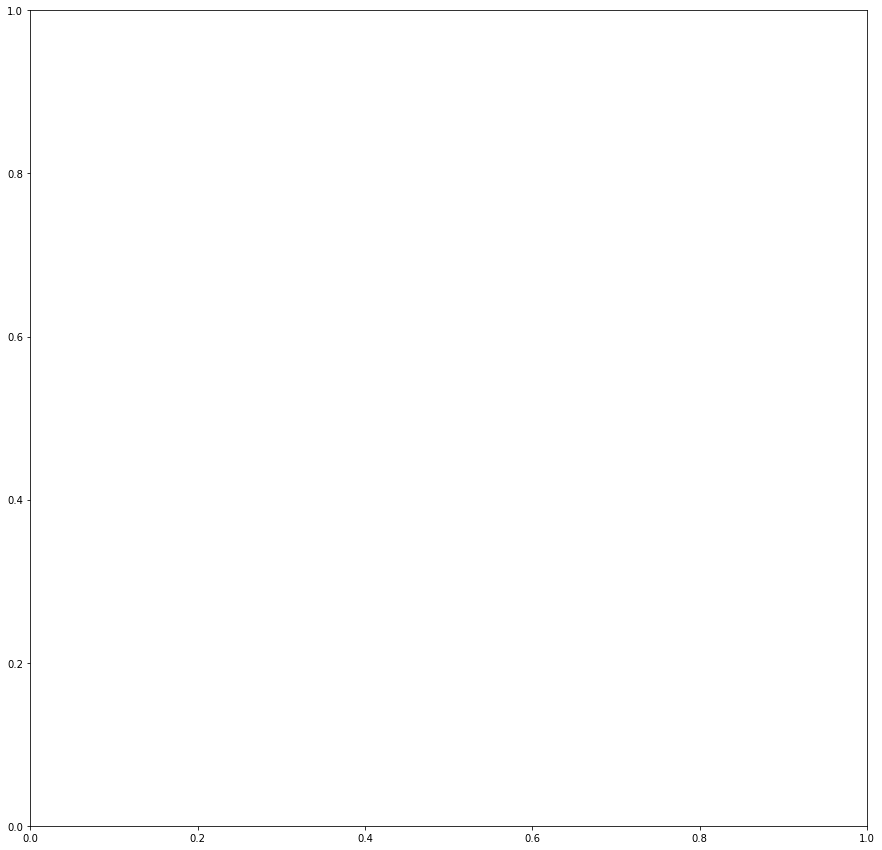

In [48]:
# Post Pandemic Map

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(15, 15))
# Generate and add KDE with a shading of 50 gradients coloured contours, 75% of transparency,
sns.kdeplot(corporate_postp['x'], corporate_postp['y'], n_levels=50, shade=True, alpha=0.55, cmap='rocket_r')
# Add basemap
cx.add_basemap(ax, crs=parcels.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=10)

# Remove axes
ax.set_axis_off()
ax.set_title('Heatmap of Post-Pandemic Corporate Owned Residential Properties')


KeyError: 'x'

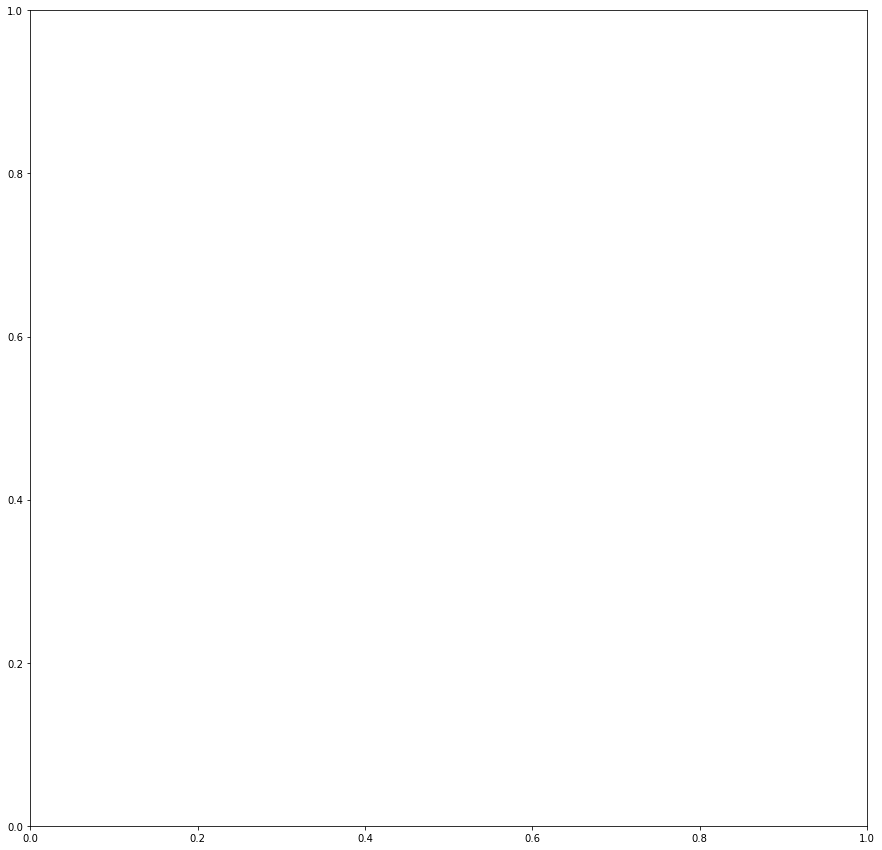

In [49]:
# Pre Pandemic Map

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(15, 15))
# Generate and add KDE with a shading of 50 gradients coloured contours, 75% of transparency,
sns.kdeplot(corporate_prep['x'], corporate_prep['y'], n_levels=50, shade=True, alpha=0.55, cmap='rocket_r')
# Add basemap
cx.add_basemap(ax, crs=parcels.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=10)

# Remove axes
ax.set_axis_off()
ax.set_title(' Heatmap of Pre-Pandemic Corporate Owned Residential Properties')

## First model post-pandemic parcels



In [50]:
#extract columns to model

postp_model = model_gdf[['YEAR_BUILT', 'EMV_TOTAL', 'AGE_DIV', 'IMM_DIV', 'RACIAL_DIV', 'PBLACKNH', 'PPOV185', \
'ACP', 'PPOV500', 'ACA', 'TR_EDA', 'INCOME_DIV', 'INC_CHG', 'OE_BC', 'NE_LW', 'NE_MW', 'NE_HW', 'PHFTRANSIT',\
'COMMLENGTH', 'PCOMMTRANS', 'PJOB_LT5', 'TR_EJ', 'ENV_PM25', 'PMV', 'NBR_STAB', 'POWNHOME', 'PCOSTBURD', \
'RP_NETCHG', 'TR_QUALIF', 'OWNER_RATIO', 'RENT_CHG', 'EMV_CHG', 'AFF_CHG', 'postp_corp', 'geometry']]

postp_model.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 950945 entries, 0 to 968440
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   YEAR_BUILT   950945 non-null  int64   
 1   EMV_TOTAL    950945 non-null  float64 
 2   AGE_DIV      950945 non-null  float64 
 3   IMM_DIV      950945 non-null  float64 
 4   RACIAL_DIV   950945 non-null  float64 
 5   PBLACKNH     950945 non-null  float64 
 6   PPOV185      950945 non-null  float64 
 7   ACP          950945 non-null  float64 
 8   PPOV500      950945 non-null  float64 
 9   ACA          950945 non-null  float64 
 10  TR_EDA       950945 non-null  float64 
 11  INCOME_DIV   950945 non-null  float64 
 12  INC_CHG      950945 non-null  float64 
 13  OE_BC        950945 non-null  float64 
 14  NE_LW        950945 non-null  float64 
 15  NE_MW        950945 non-null  float64 
 16  NE_HW        950945 non-null  float64 
 17  PHFTRANSIT   950945 non-null  float64 
 

In [51]:
# separating our independent and dependent variables

#Independent Variables
X_pp = postp_model.drop(columns=['postp_corp', 'geometry'])

#Target Variable
y_pp = postp_model['postp_corp']

In [52]:
#Verify
print(X_pp.shape)
print(y_pp.shape)
print(postp_model.shape)

(950945, 33)
(950945,)
(950945, 35)


In [53]:
# Train Test split with stratify and Smote
Xpp_train, Xpp_test, ypp_train, ypp_test = train_test_split(X_pp, y_pp, test_size=0.25, stratify= y)


# instantiate SMOTE sampler, fit it to the training data, then resample the data
Xpp_train_sm, ypp_train_sm = SMOTE().fit_resample(Xpp_train, ypp_train)

In [54]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(ypp_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(ypp_train_sm).value_counts().sort_index())

Original class distribution


0    710454
1      2754
Name: postp_corp, dtype: int64


Resampled class distribution


0    710454
1    710454
Name: postp_corp, dtype: int64

In [55]:
from sklearn.preprocessing import StandardScaler

# scale the sampled train data and the unsampled test data

#instantiate
ss_sm = StandardScaler().fit(Xpp_train_sm)

#fit to X_train and X_test

Xpp_train_sm_ss = ss_sm.transform(Xpp_train_sm)
Xpp_test_ss = ss_sm.transform(Xpp_test)

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [56]:
# Instatiate logistic model
logreg_sm_op = LogisticRegression(solver='lbfgs', C=10)

# Fit log regression model to the training data
logreg_sm_op.fit(Xpp_train_sm_ss, ypp_train_sm)

# Score
print(f"Train score: {logreg_sm_op.score(Xpp_train_sm_ss, ypp_train_sm)}")
print(f"Test score: {logreg_sm_op.score(Xpp_test_ss, ypp_test)}")

Train score: 0.6451029904821424
Test score: 0.7220373774380934


In [57]:
# class distribution
display(ypp_test.value_counts())

# predict classification
ypp_test_pred = logreg_sm_op.predict(Xpp_test_ss) # using the unsampled but scaled test data

# confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(ypp_test, ypp_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(ypp_test, ypp_test_pred)*100:0.1f}%')
print(f'Precision score: {precision_score(ypp_test, ypp_test_pred)*100:0.1f}%')
print(f'F1 score: {f1_score(ypp_test, ypp_test_pred)*100:0.1f}%')

0    236866
1       871
Name: postp_corp, dtype: int64

,predicted 0,predicted 1
true 0,171201,65665
true 1,417,454


Recall score: 52.1%
Precision score: 0.7%
F1 score: 1.4%


In [58]:
# Get Classification report
log_report = classification_report(ypp_test, ypp_test_pred)
print(log_report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84    236866
           1       0.01      0.52      0.01       871

    accuracy                           0.72    237737
   macro avg       0.50      0.62      0.43    237737
weighted avg       0.99      0.72      0.84    237737



In [59]:
#extract features from our X_train df
features = list(Xpp_train.columns.values)

#Create new dataframe with a coefficient column and a matching features column. 
#The coefficient array follows the same order as the training set.

logregpp_coefficients = pd.DataFrame({'coefficient': logreg_sm_op.coef_[0], 'variable': features})  
logregpp_coefficients.head()


,coefficient,variable
0,-0.543533,YEAR_BUILT
1,-0.071468,EMV_TOTAL
2,-0.062861,AGE_DIV
3,-0.057858,IMM_DIV
4,-0.159831,RACIAL_DIV


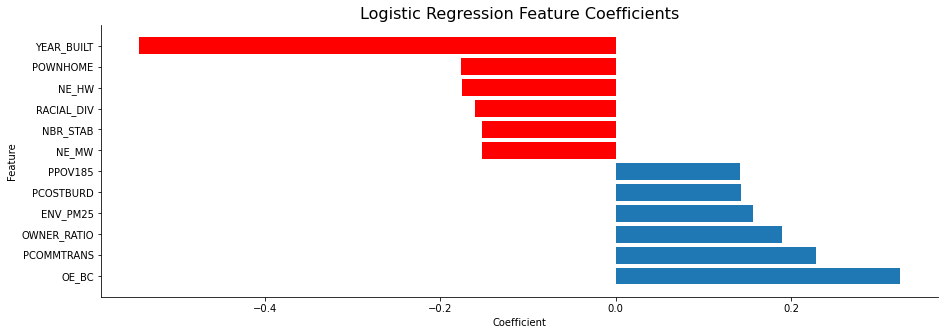

In [60]:
#Order
logregpp_coefficients_rank = logregpp_coefficients.sort_values(by = 'coefficient', ascending = False)

# most positive/negative coefficients!
neg_coeff = logregpp_coefficients_rank.tail(6)
pos_coeff = logregpp_coefficients_rank.head(6)

# Visualize
#Visualize
plt.figure(figsize=(15,5))
plt.barh(pos_coeff['variable'], pos_coeff['coefficient'])
plt.barh(neg_coeff['variable'], neg_coeff['coefficient'], color = 'r')
plt.title('Logistic Regression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()

There is a noted shift in post-pandemic corporate properties towards neighborhoods where blue collar workers live, but also where the percent who commute by public transit. Because the model's ability to predict corporate owned residential housing is so low, I don't put much stock in this particular approach.

## Logistic Regression Model Pre-Pandemic Corporate Owned Housing

After modeling (poorly) post-pandemic corporate owned housing, we will now model pre-pandemic corporate owned housing to assess if there are major differences.

In [61]:
#extract columns to model

prep_model = model_gdf[['YEAR_BUILT', 'EMV_TOTAL', 'AGE_DIV', 'IMM_DIV', 'RACIAL_DIV', 'PBLACKNH', 'PPOV185', \
'ACP', 'PPOV500', 'ACA', 'TR_EDA', 'INCOME_DIV', 'INC_CHG', 'OE_BC', 'NE_LW', 'NE_MW', 'NE_HW', 'PHFTRANSIT',\
'COMMLENGTH', 'PCOMMTRANS', 'PJOB_LT5', 'TR_EJ', 'ENV_PM25', 'PMV', 'NBR_STAB', 'POWNHOME', 'PCOSTBURD', \
'RP_NETCHG', 'TR_QUALIF', 'OWNER_RATIO', 'RENT_CHG', 'EMV_CHG', 'AFF_CHG', 'prep_corp', 'geometry']]

prep_model.head()

,YEAR_BUILT,EMV_TOTAL,AGE_DIV,IMM_DIV,RACIAL_DIV,PBLACKNH,PPOV185,ACP,PPOV500,ACA,TR_EDA,INCOME_DIV,INC_CHG,OE_BC,NE_LW,NE_MW,NE_HW,PHFTRANSIT,COMMLENGTH,PCOMMTRANS,PJOB_LT5,TR_EJ,ENV_PM25,PMV,NBR_STAB,POWNHOME,PCOSTBURD,RP_NETCHG,TR_QUALIF,OWNER_RATIO,RENT_CHG,EMV_CHG,AFF_CHG,prep_corp,geometry
0,1987,343900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,1,POINT (468988.693 5026377.395)
1,1996,382700.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469548.186 5026281.306)
2,1996,537900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469374.511 5026384.153)
3,1998,354000.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469323.226 5026492.734)
4,1995,288900.0,0.699942,0.0,0.076826,0.0,0.231,0.0,0.205,0.0,0.0,0.750102,6.059419,0.268156,0.299441,0.311173,0.121229,0.0,37.12,0.0,0.307,0.0,6.907,0.062,1.148986,0.922,0.296,33.0,0.0,0.88735,25.0,24.462236,-42.657741,0,POINT (469536.277 5026429.696)


In [62]:
# separating our independent and dependent variables

#Independent Variables
X_prep = prep_model.drop(columns=['prep_corp', 'geometry'])

#Target Variable
y_prep = prep_model['prep_corp']

In [63]:
#Verify
print(X_prep.shape)
print(y_prep.shape)
print(prep_model.shape)

(950945, 33)
(950945,)
(950945, 35)


In [64]:
# Train Test split with stratify and Smote
Xprep_train, Xprep_test, yprep_train, yprep_test = train_test_split(X_prep, y_prep, test_size=0.25, stratify= y)


# instantiate SMOTE sampler, fit it to the training data, then resample the data
Xprep_train_sm, yprep_train_sm = SMOTE().fit_resample(Xprep_train, yprep_train)

In [65]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(yprep_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(yprep_train_sm).value_counts().sort_index())

Original class distribution


0    693131
1     20077
Name: prep_corp, dtype: int64


Resampled class distribution


0    693131
1    693131
Name: prep_corp, dtype: int64

In [66]:
from sklearn.preprocessing import StandardScaler

# scale the sampled train data and the unsampled test data

#instantiate
ss_sm = StandardScaler().fit(Xprep_train_sm)

#fit to X_train and X_test

Xprep_train_sm_ss = ss_sm.transform(Xprep_train_sm)
Xprep_test_ss = ss_sm.transform(Xprep_test)

C:\Users\scox0\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [67]:
# Instatiate logistic model
logreg_sm_prep = LogisticRegression(solver='lbfgs', C=10)

# Fit log regression model to the training data
logreg_sm_prep.fit(Xprep_train_sm_ss, yprep_train_sm)

# Score
print(f"Train score: {logreg_sm_op.score(Xprep_train_sm_ss, yprep_train_sm)}")
print(f"Test score: {logreg_sm_op.score(Xprep_test_ss, yprep_test)}")

Train score: 0.6281135889175351
Test score: 0.6832550255113844


In [68]:
# class distribution
display(yprep_test.value_counts())

# predict classification
yprep_test_pred = logreg_sm_prep.predict(Xprep_test_ss) # using the unsampled but scaled test data

# confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(yprep_test, yprep_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(yprep_test, yprep_test_pred)*100:0.1f}%')
print(f'Precision score: {precision_score(yprep_test, yprep_test_pred)*100:0.1f}%')
print(f'F1 score: {f1_score(yprep_test, yprep_test_pred)*100:0.1f}%')

0    231003
1      6734
Name: prep_corp, dtype: int64

,predicted 0,predicted 1
true 0,173248,57755
true 1,2952,3782


Recall score: 56.2%
Precision score: 6.1%
F1 score: 11.1%


In [69]:
# Get Classification report
log_report = classification_report(yprep_test, yprep_test_pred)
print(log_report)

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    231003
           1       0.06      0.56      0.11      6734

    accuracy                           0.74    237737
   macro avg       0.52      0.66      0.48    237737
weighted avg       0.96      0.74      0.83    237737



In [70]:
#extract features from our X_train df
features = list(Xprep_train.columns.values)

#Create new dataframe with a coefficient column and a matching features column. 
#The coefficient array follows the same order as the training set.

logregprep_coefficients = pd.DataFrame({'coefficient': logreg_sm_prep.coef_[0], 'variable': features})  
logregprep_coefficients.head()


,coefficient,variable
0,-0.601227,YEAR_BUILT
1,-0.121925,EMV_TOTAL
2,-0.002274,AGE_DIV
3,-0.080878,IMM_DIV
4,-0.020263,RACIAL_DIV


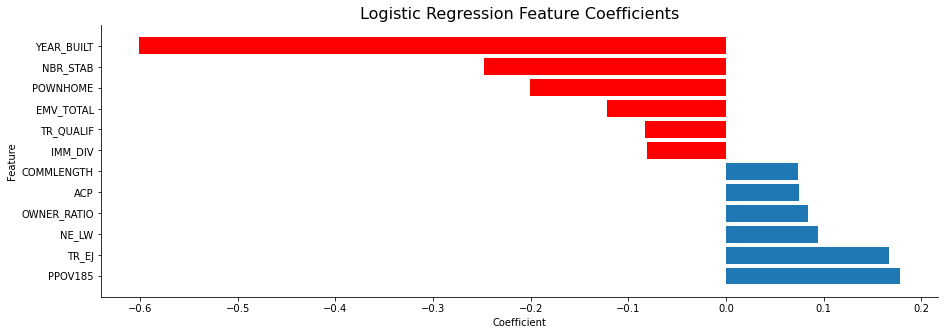

In [71]:
#Order
logregprep_coefficients_rank = logregprep_coefficients.sort_values(by = 'coefficient', ascending = False)

# most positive/negative coefficients!
neg_coeff_prep = logregprep_coefficients_rank.tail(6)
pos_coeff_prep = logregprep_coefficients_rank.head(6)

# Visualize
#Visualize
plt.figure(figsize=(15,5))
plt.barh(pos_coeff_prep['variable'], pos_coeff_prep['coefficient'])
plt.barh(neg_coeff_prep['variable'], neg_coeff_prep['coefficient'], color = 'r')
plt.title('Logistic Regression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()